In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Cleaning
First, I loaded the dataframe from the csv.

In [ ]:
data = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
data

Next, I mapped RainToday and RainTomorrow to 0 and 1 and seperated categorical data from continuous data.

In [ ]:
# Map rain data
yes_no = {"Yes": 1, "No": 0}
data['RainToday'] = data['RainToday'].map(yes_no)
data['RainTomorrow'] = data['RainTomorrow'].map(yes_no)

categorical = []
continuous = []

# Seperate data by type
for col in data.columns:
    if(data[col].dtype == 'float64'):
        continuous.append(col)
    else:
        categorical.append(col)

print(categorical)
print(continuous)

# Exploratory Data Analysis
Next, I took a look at the distributions of the continuous data, seperating dry (RainTomorrow = 0) from rain (RainTomorrow = 1) days.

In [ ]:
import matplotlib.pyplot as plt

'''
for type in continuous:
    rain_count = {}
    dry_count = {}
    for pair in data[[type, 'RainTomorrow']].values:
        if pair[0] in rain_count:
            rain_count[pair[0]] += pair[1]
        else:
            rain_count[pair[0]] = pair[1]

        if pair[0] in dry_count:
            dry_count[pair[0]] += int(pair[1] == 0)
        else:
            dry_count[pair[0]] = int(pair[1] == 0)


    x_rain = []
    y_rain = []

    for t in sorted(list(rain_count.keys())):
        x_rain.append(t)
        y_rain.append(rain_count[t])

    x_dry = []
    y_dry = []

    for t in sorted(list(dry_count.keys())):
        x_dry.append(t)
        y_dry.append(dry_count[t])

    plt.title('Distribution Dry/Rain Tomorrow Against ' + str(type))
    plt.xlabel(type)
    plt.ylabel('Frequency')
    plt.bar(x_dry,y_dry, color='grey', label='Dry', width=1.0)
    plt.bar(x_rain,y_rain, color='blue', label='Rain', width=1.0)
    plt.legend()
    plt.show()
'''

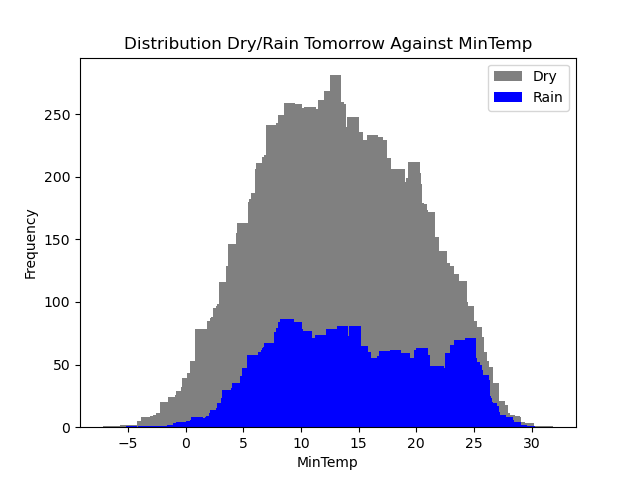
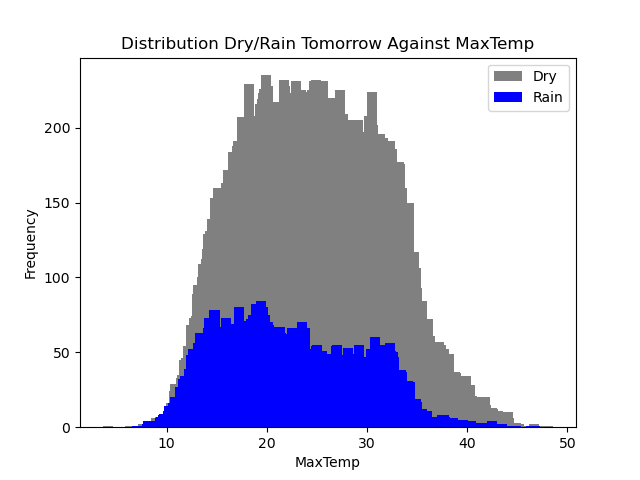
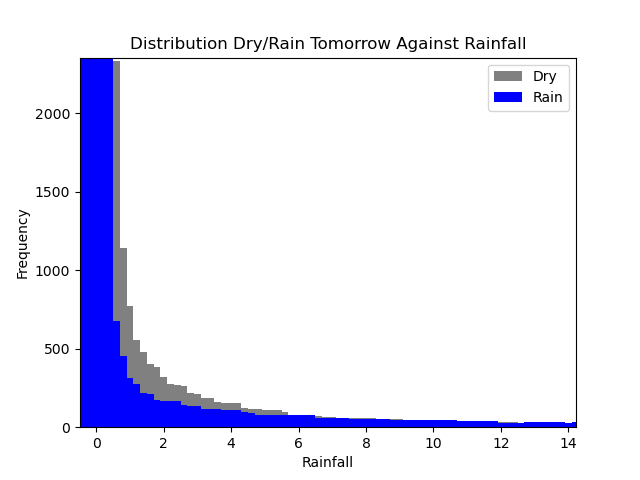
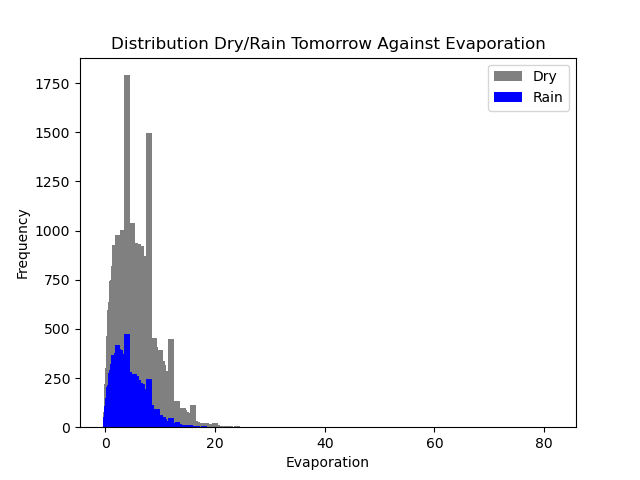
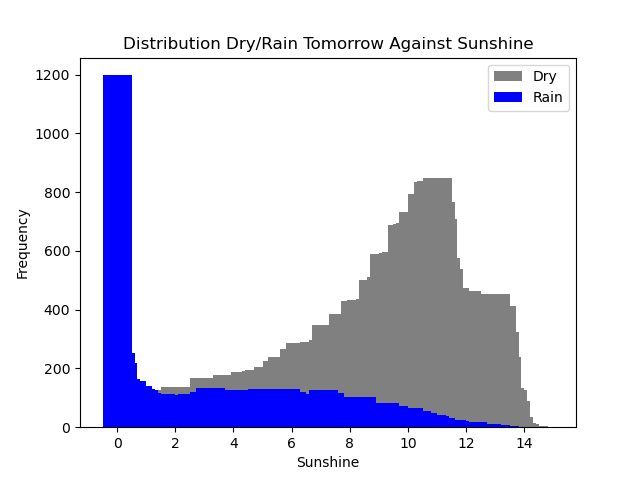
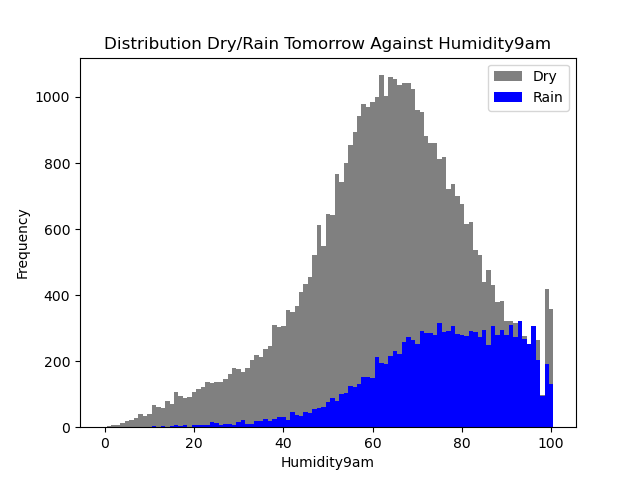
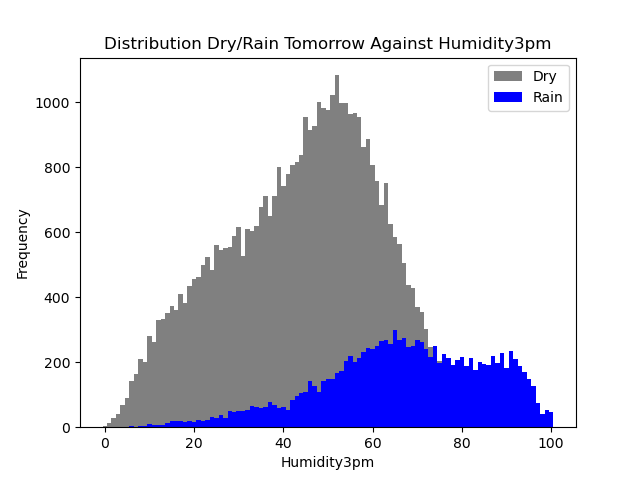
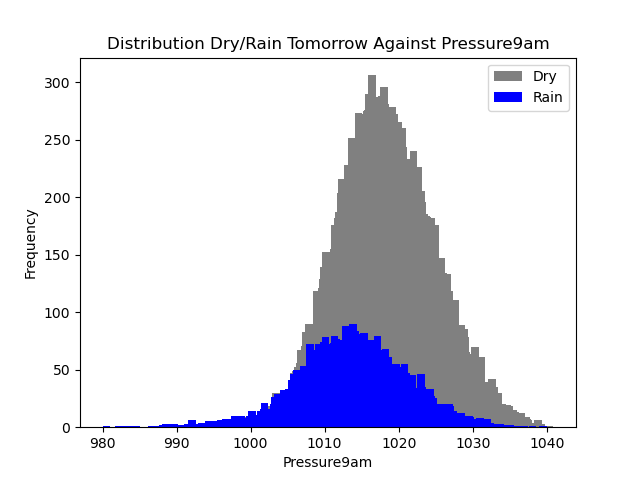
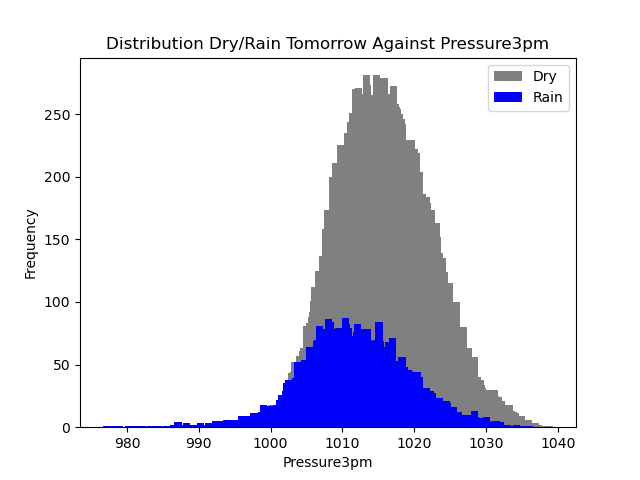
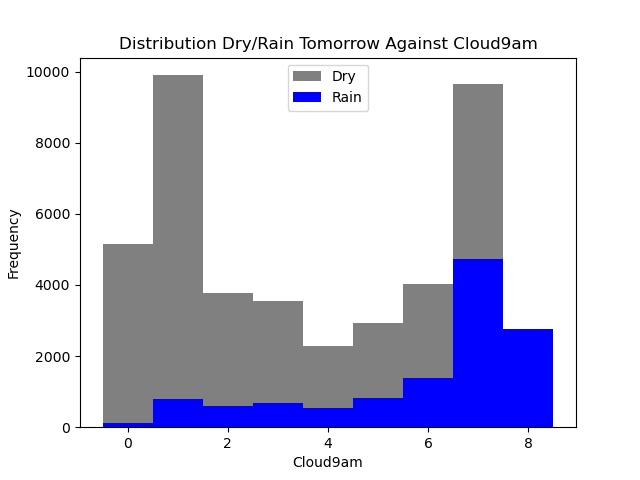
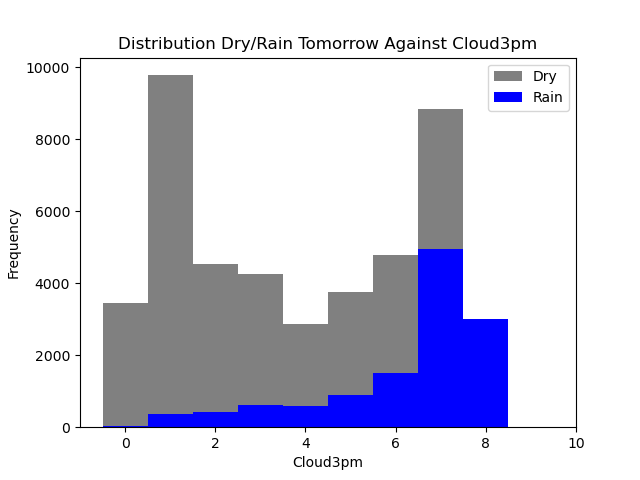
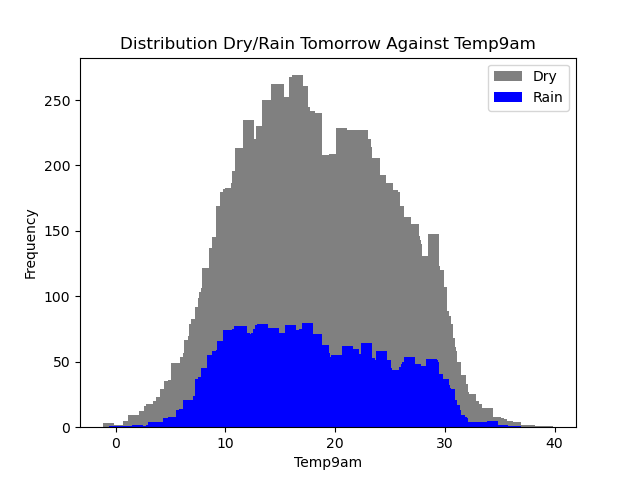
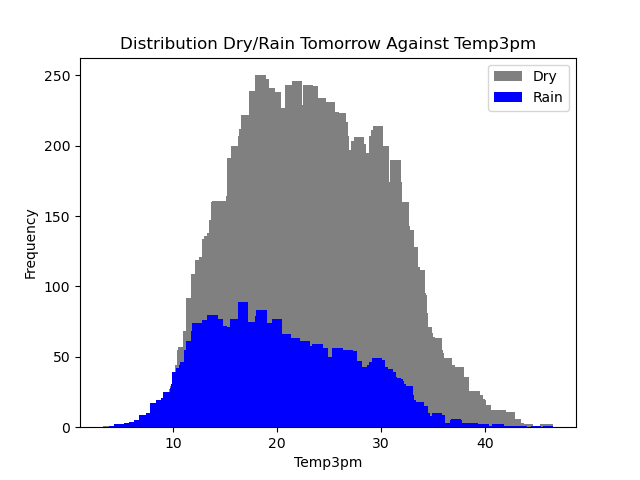

I replaced the Max and Min temperatures with the temperature difference between these two values in order to take drastic temperature changes into account when making the predictions.

In [ ]:
# Get Temperature difference between min temp and max temp
import numpy as np
to_replace = np.full(len(data.index), 'NA')
for i in data[['MaxTemp', 'MinTemp']].index:
    to_replace[i] = data['MaxTemp'][i] - data['MinTemp'][i]

# Put new col in dataframe
data['TempDiff'] = to_replace

I then dropped the NA values and saved RainTommorow to use in the testing phase. Later I plan on incorporating categorical data in the predictions, but for know I just ignored them.

In [ ]:
# Drop NA and the Temperatures we replaced with their difference
data = data.dropna(how='any')
data = data.drop(['MinTemp','MaxTemp'], axis=1)

# Save output values to split later
y = data['RainTomorrow'].values
del data['RainTomorrow']
continuous.remove('RainTomorrow')

data = data.drop(categorical, axis=1)

# Predictions
I then scaled my continuous data and used logistical regression to make predictions on whether or not it will rain tomorrow.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Use train_test_split to get test and training data
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.3)

# Scale our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = LogisticRegression(random_state=1)
classifier.fit(X_train,Y_train)

predictions = classifier.predict(X_test)
confusion = confusion_matrix(Y_test, predictions)

# Accuracy is correct guesses / total guesses
print("Accuracy: " + str(confusion[0][0]/(confusion[0][0] + confusion[1][0])))
